In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [2]:
df_T=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Temperature_Value.csv', sep=';')
df_stir=pd.read_csv('fermentation raw data/May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Stirrer_Value.csv', sep=';')
df_feed1=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Feed 1_Value.csv', sep=';')
#df_feed2=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Feed 2_Value.csv', sep=';')
#df_pumpfeed1=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Feed 1_Value.csv', sep=';')
#df_pumpfeed2=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Feed 2_Value.csv', sep=';')
df_base=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Base_Value.csv', sep=';')
#df_antifoam=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Antifoam_Value.csv', sep=';')
df_acid=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Pump - Acid_Value.csv', sep=';')
df_pO2=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pO₂_Value.csv', sep=';')
df_pH=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_pH_Value.csv', sep=';')
#df_CO2=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Flow - CO₂_Value.csv', sep=';')
df_air=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Flow - Air_Value.csv', sep=';')
#df_level=pd.read_csv('fermentation raw data\May 26, 2023_10 58 18 AM_DTU 3-parameterValues_Levelsensor_Value.csv', sep=';')
df_offgas=pd.read_excel('fermentation raw data\offgas_data.xlsx')

In [3]:
parameters_df=[df_T, df_stir, df_feed1, df_base, df_acid, df_pO2, df_pH, df_air]

In [4]:
start = '31-05-2023 10:14:00'
end = '02-06-2023 06:00:00'
start_time = datetime.strptime(start, '%d-%m-%Y %H:%M:%S')
end_time = datetime.strptime(end, '%d-%m-%Y %H:%M:%S')

In [5]:
df_merged=pd.DataFrame()
for df in parameters_df:
    df_copy=df.copy()
    df_copy.insert(0, 'DateTime', df_copy['Date'].astype(str)+' '+df_copy['Time'].astype(str))
    df_copy['DateTime']=pd.to_datetime(df_copy['DateTime'], format='%b %d, %Y %I:%M:%S %p')
    df_grouped=df_copy.groupby(df_copy['DateTime'].dt.strftime('%Y-%m-%dT%H:%M')).first()
    df_grouped['strings']=df_grouped['DateTime'].dt.strftime("%Y-%m-%d %H:%M")+ ':00'
    df_grouped['DateTime']=pd.to_datetime(df_grouped['strings'], format='%Y-%m-%d %H:%M:%S')
    df_grouped.drop(['Date', 'Time', 'strings'], axis=1, inplace=True)
    df_grouped[df_grouped.columns[1]]=df_grouped[df_grouped.columns[1]].str.replace(',', '.')
    df_grouped[df_grouped.columns[1]]=pd.to_numeric(df_grouped[df_grouped.columns[1]], errors='coerce')
    df_se=df_grouped[(df_grouped['DateTime'] > start_time) & (df_grouped['DateTime'] < end_time)]
    df_se = df_se.reset_index(drop=True)
    if df_merged.empty:
        df_merged=df_se
    else:
        df_merged=df_merged.merge(df_se, on='DateTime', how='inner')

In [6]:
df_merged.head()

,DateTime,Temperature Value (°C),Stirrer Value (rpm),Feed 1 Value (%),Pump - Base Value (%),Pump - Acid Value (%),pO₂ Value (pO₂),pH Value (pH),Flow - Air Value
0,2023-05-31 10:15:00,29.88,295.08,0.0,0.0,0.0,77.91,7.03,1.0
1,2023-05-31 10:16:00,29.85,292.41,0.0,0.0,0.0,66.31,7.02,1.0
2,2023-05-31 10:17:00,29.87,296.30,0.0,0.0,0.0,64.32,7.02,1.0
3,2023-05-31 10:18:00,29.77,293.57,0.0,0.0,0.0,53.72,7.01,1.0
4,2023-05-31 10:19:00,29.76,291.77,0.0,0.0,0.0,52.38,7.01,1.0


In [7]:
df_off_grouped=df_offgas.groupby(df_offgas['Timestamp'].dt.strftime('%Y-%m-%dT%H:%M')).first()
df_off_grouped.reset_index(drop=True, inplace=True)
df_off_grouped['strings']=df_off_grouped['Timestamp'].dt.strftime("%Y-%m-%d %H:%M")+ ':00'
df_off_grouped['DateTime']=pd.to_datetime(df_off_grouped['strings'], format='%Y-%m-%d %H:%M:%S')
df_off_grouped.drop(['Timestamp', 'strings'], axis=1, inplace=True)
df_off_grouped=df_off_grouped[(df_off_grouped['DateTime'] > start_time) & (df_off_grouped['DateTime'] < end_time)]
df_off_grouped.shape

(2625, 7)

In [8]:
total_df=df_merged.merge(df_off_grouped, on='DateTime', how='inner')
df_filter=total_df.drop(['offg_ethanol', 'offg_methanol', 'offg_RMS'], axis=1, inplace=False)
first_timestamp = df_filter['DateTime'].iloc[0]  # Get the first timestamp
df_filter['duration [h]'] = (df_filter['DateTime'] - first_timestamp) / pd.Timedelta(hours=1)
df_filter['duration [h]']=df_filter['duration [h]'].round(2)
df_filter

,DateTime,Temperature Value (°C),Stirrer Value (rpm),Feed 1 Value (%),Pump - Base Value (%),Pump - Acid Value (%),pO₂ Value (pO₂),pH Value (pH),Flow - Air Value,offg_co2,offg_n2,offg_o2,duration [h]
0,2023-05-31 10:15:00,29.88,295.08,0.0,0.0,0.00,77.91,7.03,1.0,0.039013,77.502221,21.178293,0.00
1,2023-05-31 10:16:00,29.85,292.41,0.0,0.0,0.00,66.31,7.02,1.0,0.039162,77.492184,21.179474,0.02
2,2023-05-31 10:17:00,29.87,296.30,0.0,0.0,0.00,64.32,7.02,1.0,0.039200,77.505519,21.176716,0.03
3,2023-05-31 10:18:00,29.77,293.57,0.0,0.0,0.00,53.72,7.01,1.0,0.039410,77.513174,21.172557,0.05
4,2023-05-31 10:19:00,29.76,291.77,0.0,0.0,0.00,52.38,7.01,1.0,0.040346,77.511467,21.173347,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,2023-06-02 05:55:00,29.92,998.80,17.0,0.0,20.50,4.86,7.05,2.0,1.905668,77.233778,19.395615,43.67
2621,2023-06-02 05:56:00,29.87,998.37,17.0,0.0,20.51,6.86,7.05,2.0,1.905352,77.234260,19.395984,43.68
2622,2023-06-02 05:57:00,29.94,998.95,17.0,0.0,0.00,5.22,7.05,2.0,1.905450,77.235100,19.395451,43.70
2623,2023-06-02 05:58:00,29.95,998.15,17.0,0.0,0.00,5.40,7.05,2.0,1.907063,77.233744,19.394907,43.72


In [9]:
df_biomass=pd.read_csv('fermentation raw data/biomass.csv', sep=';')
for col in df_biomass.columns:
    df_biomass[col]=df_biomass[col].str.replace(',', '.')
    df_biomass[col]=pd.to_numeric(df_biomass[col])
df_biomass.head(3)

,biomass (g/L),duration [h]
0,0.694,0.2
1,1.311,2.1
2,1.542,2.3


In [10]:
df_included = df_filter.merge(df_biomass, on='duration [h]', how='left')
df_included['biomass (g/L)']=df_included['biomass (g/L)'].replace('', np.nan)
df_included

,DateTime,Temperature Value (°C),Stirrer Value (rpm),Feed 1 Value (%),Pump - Base Value (%),Pump - Acid Value (%),pO₂ Value (pO₂),pH Value (pH),Flow - Air Value,offg_co2,offg_n2,offg_o2,duration [h],biomass (g/L)
0,2023-05-31 10:15:00,29.88,295.08,0.0,0.0,0.00,77.91,7.03,1.0,0.039013,77.502221,21.178293,0.00,NaN
1,2023-05-31 10:16:00,29.85,292.41,0.0,0.0,0.00,66.31,7.02,1.0,0.039162,77.492184,21.179474,0.02,NaN
2,2023-05-31 10:17:00,29.87,296.30,0.0,0.0,0.00,64.32,7.02,1.0,0.039200,77.505519,21.176716,0.03,NaN
3,2023-05-31 10:18:00,29.77,293.57,0.0,0.0,0.00,53.72,7.01,1.0,0.039410,77.513174,21.172557,0.05,NaN
4,2023-05-31 10:19:00,29.76,291.77,0.0,0.0,0.00,52.38,7.01,1.0,0.040346,77.511467,21.173347,0.07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,2023-06-02 05:55:00,29.92,998.80,17.0,0.0,20.50,4.86,7.05,2.0,1.905668,77.233778,19.395615,43.67,NaN
2621,2023-06-02 05:56:00,29.87,998.37,17.0,0.0,20.51,6.86,7.05,2.0,1.905352,77.234260,19.395984,43.68,NaN
2622,2023-06-02 05:57:00,29.94,998.95,17.0,0.0,0.00,5.22,7.05,2.0,1.905450,77.235100,19.395451,43.70,NaN
2623,2023-06-02 05:58:00,29.95,998.15,17.0,0.0,0.00,5.40,7.05,2.0,1.907063,77.233744,19.394907,43.72,NaN


In [12]:
df_included['cum. base feed [ml/min]']=(df_included['Pump - Base Value (%)'].cumsum())/10
df_included['cum. acid feed [ml/min]']=(df_included['Pump - Acid Value (%)'].cumsum())/10

In [11]:
df_included.columns

Index(['DateTime', 'Temperature Value (°C)', 'Stirrer Value (rpm)',
       'Feed 1 Value (%)', 'Pump - Base Value (%)', 'Pump - Acid Value (%)',
       'pO₂ Value (pO₂)', 'pH Value (pH)', 'Flow - Air Value', 'offg_co2',
       'offg_n2', 'offg_o2', 'duration [h]', 'biomass (g/L)'],
      dtype='object')

In [11]:
df_included['Glucose feed [ml/min]']=df_included['Feed 1 Value (%)']*350/10
df_included['DO2 - smoothed']=df_included['pO₂ Value (pO₂)'].ewm(alpha=0.1).mean()
df_included['Stirring [rpm]- smoothed']=df_included['Stirrer Value (rpm)'].ewm(alpha=0.1).mean()
df_included['T [°C]- smoothed']=df_included['Temperature Value (°C)'].ewm(alpha=0.1).mean()
df_included.head()

,DateTime,Temperature Value (°C),Stirrer Value (rpm),Feed 1 Value (%),Pump - Base Value (%),Pump - Acid Value (%),pO₂ Value (pO₂),pH Value (pH),Flow - Air Value,offg_co2,offg_n2,offg_o2,duration [h],biomass (g/L),Glucose feed [ml/min],DO2 - smoothed,Stirring [rpm]- smoothed,T [°C]- smoothed
0,2023-05-31 10:15:00,29.88,295.08,0.0,0.0,0.0,77.91,7.03,1.0,0.039013,77.502221,21.178293,0.00,NaN,0.0,77.910000,295.080000,29.880000
1,2023-05-31 10:16:00,29.85,292.41,0.0,0.0,0.0,66.31,7.02,1.0,0.039162,77.492184,21.179474,0.02,NaN,0.0,71.804737,293.674737,29.864211
2,2023-05-31 10:17:00,29.87,296.30,0.0,0.0,0.0,64.32,7.02,1.0,0.039200,77.505519,21.176716,0.03,NaN,0.0,69.042841,294.643469,29.866347
3,2023-05-31 10:18:00,29.77,293.57,0.0,0.0,0.0,53.72,7.01,1.0,0.039410,77.513174,21.172557,0.05,NaN,0.0,64.587232,294.331323,29.838331
4,2023-05-31 10:19:00,29.76,291.77,0.0,0.0,0.0,52.38,7.01,1.0,0.040346,77.511467,21.173347,0.07,NaN,0.0,61.606296,293.705863,29.819203


In [12]:
df_included.rename(columns={'Temperature Value (°C)': 'Temperature [°C]', 'Stirrer Value (rpm)': 'Stirrer [rpm]', 'biomass (g/L)': 'Biomass [g/L]'}, errors='raise', inplace=True)
df_included.rename(columns={'offg_co2': 'Offgas CO2 [%]', 'offg_n2': 'Offgas N2 [%]', 'offg_o2': 'Offgas O2 [%]', 'duration [h]': 'time [h]'}, inplace=True)
df_included.head()

,DateTime,Temperature [°C],Stirrer [rpm],Feed 1 Value (%),Pump - Base Value (%),Pump - Acid Value (%),pO₂ Value (pO₂),pH Value (pH),Flow - Air Value,Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],time [h],Biomass [g/L],Glucose feed [ml/min],DO2 - smoothed,Stirring [rpm]- smoothed,T [°C]- smoothed
0,2023-05-31 10:15:00,29.88,295.08,0.0,0.0,0.0,77.91,7.03,1.0,0.039013,77.502221,21.178293,0.00,NaN,0.0,77.910000,295.080000,29.880000
1,2023-05-31 10:16:00,29.85,292.41,0.0,0.0,0.0,66.31,7.02,1.0,0.039162,77.492184,21.179474,0.02,NaN,0.0,71.804737,293.674737,29.864211
2,2023-05-31 10:17:00,29.87,296.30,0.0,0.0,0.0,64.32,7.02,1.0,0.039200,77.505519,21.176716,0.03,NaN,0.0,69.042841,294.643469,29.866347
3,2023-05-31 10:18:00,29.77,293.57,0.0,0.0,0.0,53.72,7.01,1.0,0.039410,77.513174,21.172557,0.05,NaN,0.0,64.587232,294.331323,29.838331
4,2023-05-31 10:19:00,29.76,291.77,0.0,0.0,0.0,52.38,7.01,1.0,0.040346,77.511467,21.173347,0.07,NaN,0.0,61.606296,293.705863,29.819203


In [13]:
df_included.sort_index(axis=1, inplace=True)
df_included.head()

,Biomass [g/L],DO2 - smoothed,DateTime,Feed 1 Value (%),Flow - Air Value,Glucose feed [ml/min],Offgas CO2 [%],Offgas N2 [%],Offgas O2 [%],Pump - Acid Value (%),Pump - Base Value (%),Stirrer [rpm],Stirring [rpm]- smoothed,T [°C]- smoothed,Temperature [°C],pH Value (pH),pO₂ Value (pO₂),time [h]
0,NaN,77.910000,2023-05-31 10:15:00,0.0,1.0,0.0,0.039013,77.502221,21.178293,0.0,0.0,295.08,295.080000,29.880000,29.88,7.03,77.91,0.00
1,NaN,71.804737,2023-05-31 10:16:00,0.0,1.0,0.0,0.039162,77.492184,21.179474,0.0,0.0,292.41,293.674737,29.864211,29.85,7.02,66.31,0.02
2,NaN,69.042841,2023-05-31 10:17:00,0.0,1.0,0.0,0.039200,77.505519,21.176716,0.0,0.0,296.30,294.643469,29.866347,29.87,7.02,64.32,0.03
3,NaN,64.587232,2023-05-31 10:18:00,0.0,1.0,0.0,0.039410,77.513174,21.172557,0.0,0.0,293.57,294.331323,29.838331,29.77,7.01,53.72,0.05
4,NaN,61.606296,2023-05-31 10:19:00,0.0,1.0,0.0,0.040346,77.511467,21.173347,0.0,0.0,291.77,293.705863,29.819203,29.76,7.01,52.38,0.07


In [14]:
df_included.to_csv('fermentation raw data/data_combined.csv')

C:\Users\dxp2904\AppData\Local\Temp\ipykernel_10976\3171771171.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap1 = plt.cm.get_cmap('Set1')


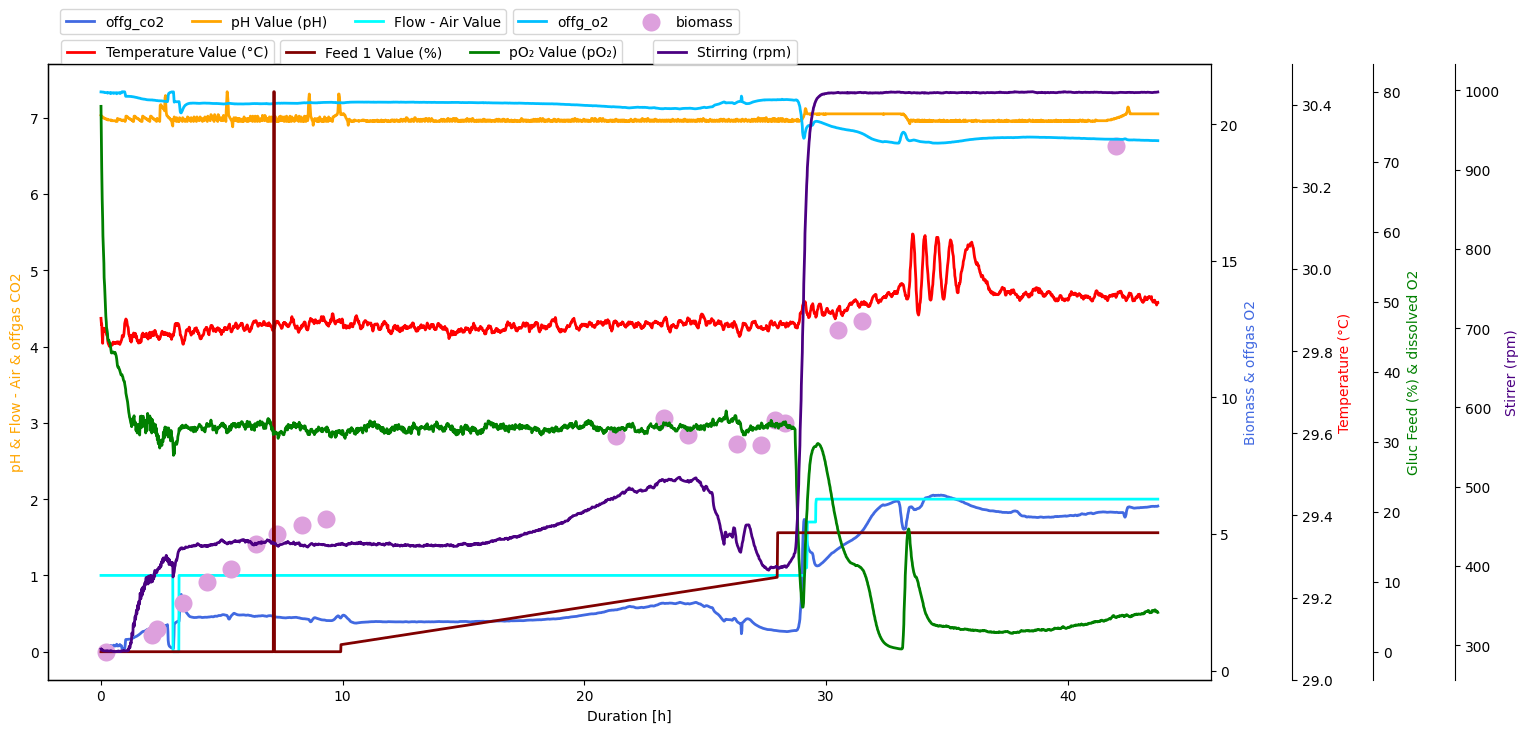

In [99]:
fig, ax = plt.subplots(1,1,figsize=(15,8))

colormap1 = plt.cm.get_cmap('Set1')

ax_sec=ax.twinx()
ax_third=ax.twinx()
ax_4th=ax.twinx()
ax_5th=ax.twinx()
ax_5th.plot(df_included['duration [h]'], df_included['smoothed Stirring'], label='Stirring (rpm)', color='indigo', linewidth=2)

ax_4th.plot(df_included['duration [h]'], df_included['Feed 1 Value (%)'], label='Feed 1 Value (%)', color='maroon', linewidth=2)
ax_4th.plot(df_included['duration [h]'], df_included['smoothed DO2'], label='pO₂ Value (pO₂)', color='green', linewidth=2)

ax_third.plot(df_included['duration [h]'], df_included['smoothed T [°C]'], label='Temperature Value (°C)', color='red', linewidth=2)
ax_third.set_ylim(29,30.5)

ax_sec.plot(df_included['duration [h]'], df_included['offg_o2'], label='offg_o2', color='deepskyblue', linewidth=2)

ax.plot(df_included['duration [h]'], df_included['offg_co2'], label='offg_co2', color='royalblue', linewidth=2)
ax.plot(df_included['duration [h]'], df_included['pH Value (pH)'], label='pH Value (pH)', color='orange', linewidth=2)
ax.plot(df_included['duration [h]'], df_included['Flow - Air Value'], label='Flow - Air Value', color='aqua', linewidth=2)

ax_sec.scatter(df_included['duration [h]'], df_included['biomass (g/L)'], linewidth=7, color='plum', label='biomass')

ax_third.spines.right.set_position(("axes", 1.07))
ax_4th.spines.right.set_position(("axes", 1.14))
ax_5th.spines.right.set_position(("axes", 1.21))

ax.set_xlabel('Duration [h]')
ax.set_ylabel('pH & Flow - Air & offgas CO2', color='orange')
ax_sec.set_ylabel('Biomass & offgas O2', color='royalblue')
ax_4th.set_ylabel('Feed 1 (%), pO₂')
ax_third.set_ylabel('Temperature (°C)', color='red')
ax_4th.set_ylabel('Gluc Feed (%) & dissolved O2', color='green')
ax_5th.set_ylabel('Stirrer (rpm)', color='indigo')

ax.legend(ncols=3, bbox_to_anchor=(0.4, 1.1))
ax_sec.legend(ncols=2, bbox_to_anchor=(0.6, 1.1))
ax_third.legend(bbox_to_anchor=(0.2, 1.05))
ax_4th.legend(ncols=2, bbox_to_anchor=(0.5, 1.05))
ax_5th.legend(bbox_to_anchor=(0.65, 1.05))
plt.show()

C:\Users\dxp2904\AppData\Local\Temp\ipykernel_19312\3065407346.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap1 = plt.cm.get_cmap('Set1')


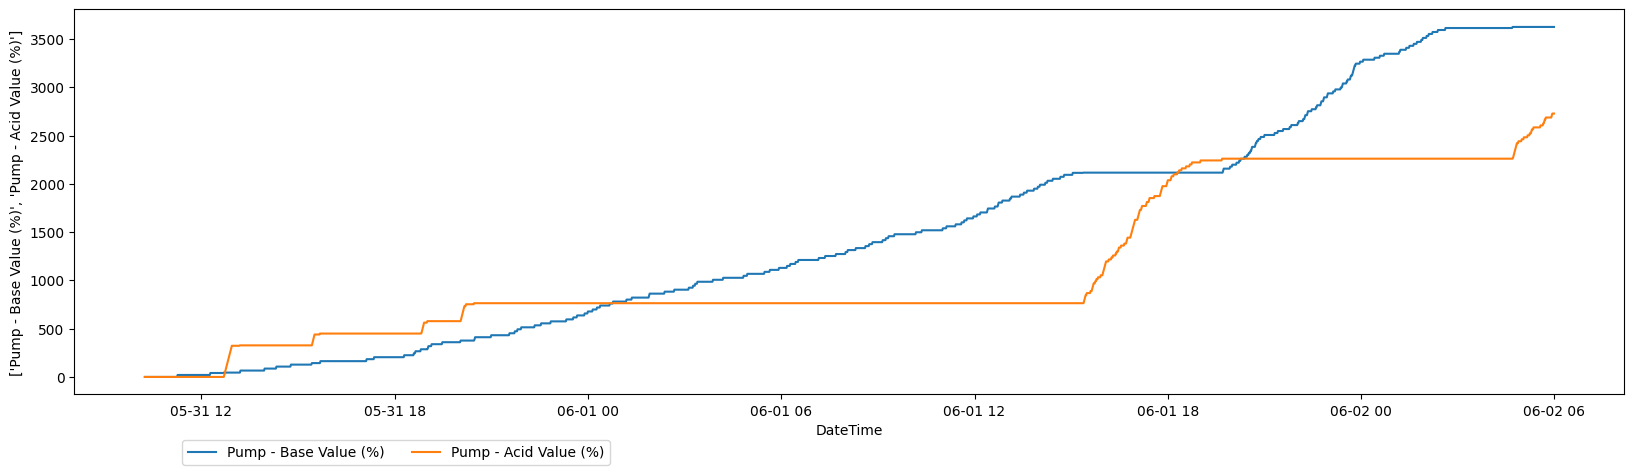

In [251]:
fig, ax = plt.subplots(2,5,figsize=(20,10))

ax.plot(df_included['DateTime'], df_included[['base feed', 'acid feed']], label=['Pump - Base Value (%)', 'Pump - Acid Value (%)'])

ax.set_xlabel('DateTime')
ax.set_ylabel(['Pump - Base Value (%)', 'Pump - Acid Value (%)'])
ax.legend(ncols=3, bbox_to_anchor=(0.35, -0.1))
plt.show()